In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2

import functions as fn

In [2]:
dataDir='../data'
trainDir='train2017'
valDir='val2017'

trainAnn=f'{dataDir}/annotations/instances_{trainDir}.json'
valAnn=f'{dataDir}/annotations/instances_{valDir}.json'

cocoTrain=COCO(trainAnn)
cocoVal=COCO(valAnn)

catIdsTrain = cocoTrain.getCatIds(catNms=['person'])
imgIdsTrain = cocoTrain.getImgIds(catIds=catIdsTrain)
imgIdsTrain = cocoTrain.getImgIds(imgIds=imgIdsTrain)

catIdsVal = cocoVal.getCatIds(catNms=['person'])
imgIdsVal = cocoVal.getImgIds(catIds=catIdsVal)
imgIdsVal = cocoVal.getImgIds(imgIds=imgIdsVal)

loading annotations into memory...
Done (t=9.88s)
creating index...
index created!
loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


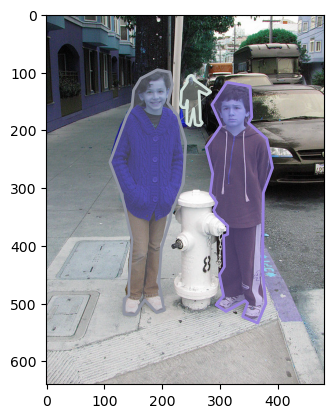

In [3]:
img = {'license': 3,
 'file_name': '000000102771.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000102771.jpg',
 'height': 640,
 'width': 480,
 'date_captured': '2013-11-16 21:36:01',
 'flickr_url': 'http://farm4.staticflickr.com/3141/3060074174_c540b56d2e_z.jpg',
 'id': 102771}

fpath = '{}/{}/{}'.format(dataDir, trainDir, img['file_name'])

test_img = cv2.imread(fpath, -1)

test_img = fn.remove_true_blacks(test_img)

plt.imshow(test_img)

anns_ids = cocoTrain.getAnnIds(imgIds=img['id'], catIds=catIdsTrain, iscrowd=None)
anns = cocoTrain.loadAnns(anns_ids)
cocoTrain.showAnns(anns)

In [4]:
ann = anns[0]

test_masked_img, test_masked_img_inv = fn.generate_masked_images(test_img, ann)

fn.display_image(test_masked_img, window_name='Masked')

In [5]:
fn.display_image(test_masked_img_inv, window_name='Inverse masked')

In [6]:
shift_interval = 10

xmin = int(np.round(ann['bbox'][0]))
xmax = int(np.round(ann['bbox'][0] + ann['bbox'][2]))
ymin = int(np.round(ann['bbox'][1]))
ymax = int(np.round(ann['bbox'][1] + ann['bbox'][3]))

xmin, xmax, ymin, ymax

(110, 241, 95, 519)

In [7]:
def shift_array(lst, displace=1, direction='right'):
    match direction:
        case 'left':
            return np.append(lst[displace:], lst[:displace], axis=0)
        case 'right':
            return np.append(lst[-displace:], lst[:-displace], axis=0)
        case _:
            raise ValueError('Inappropriate direction argument')

In [8]:
#fn.coco_polyseg_formatted(ann)

In [9]:
lst = np.array([1, 2, 3, 4, 5])
shift_array(lst, 2)

array([4, 5, 1, 2, 3])

In [10]:
fn.shift_array(lst, 1, direction='left')

array([2, 3, 4, 5, 1])

In [11]:
fn.shift_array(lst)

array([5, 1, 2, 3, 4])

In [12]:
test_arr = np.copy(test_masked_img)

In [13]:
fn.display_image(test_arr)

In [14]:
test_arr.shape

(640, 480, 3)

In [15]:
test_arr = np.copy(test_masked_img)

for row in np.arange(test_arr.shape[0]):
    test_arr[row] = fn.shift_array(test_arr[row], int(row / 4))

fn.display_image(test_arr)

In [16]:
test_arr[0].shape

(480, 3)

In [17]:
3*480

1440

In [18]:
shift_array(test_arr[0])

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=uint8)

In [19]:
np.arange(ymin, ymax)

array([ 95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185,
       186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 27

In [20]:
test_arr = np.copy(test_masked_img)

for row in np.arange(ymin - 1, ymax + 1):
    test_arr[row] = fn.shift_array(test_arr[row], int(row / 4))

fn.display_image(test_arr)

In [32]:
def apply_rolling_shutter(masked_img, inv_masked_img, ann, interval=5, strategy='right'):
    masked_output = np.copy(masked_img)
    inv_masked_output = np.copy(inv_masked_img)

    ymin = int(np.round(ann['bbox'][1]))
    ymax = int(np.round(ann['bbox'][1] + ann['bbox'][3]))

    for row in np.arange(ymin - 1, ymax + 1):
        masked_output[row] = fn.shift_array(masked_output[row], int(row / interval), direction=strategy)
    
    return masked_output

test_post_rs = apply_rolling_shutter(test_masked_img, test_masked_img_inv, ann, interval=8, strategy='left')


In [22]:
fn.display_image(test_masked_img)

In [23]:
def inverse_blacks(img):
    output = np.copy(img)
    for x, y, z in np.ndindex(img.shape):
        temp = img[x][y]
        if np.sum(temp) == 0:
            output[x][y] = np.array([255, 255, 255])
    return output

In [24]:
fn.display_image(fn.inverse_blacks(test_masked_img))

In [34]:
def recombine_masked_imgs(masked_img, inv_masked_img):
    output = np.copy(inv_masked_img)
    for x, y, z in np.ndindex(inv_masked_img.shape):
        temp = masked_img[x][y]
        if np.sum(temp) > 0:
            output[x][y] = temp
    return output

fn.display_image(recombine_masked_imgs(test_post_rs, test_masked_img_inv))

In [38]:
test_arr = np.copy(test_masked_img_inv)

np.where(test_arr == [0, 0, 0])

(array([  0,   0,   0, ..., 519, 519, 519], dtype=int64),
 array([282, 282, 293, ..., 153, 153, 153], dtype=int64),
 array([0, 2, 0, ..., 0, 1, 2], dtype=int64))

In [44]:
mask = test_img == 0

mask

array([[[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False],
        [False, False, False],
        ...,
        [False, False, False],
        [False, False, False],
        [False,